#### Import calls

In [224]:
import distutils.util
import os

%env MUJOCO_GL=glfw
%env PYOPENGL_PLATFORM=glx
%env LIBGL_ALWAYS_SOFTWARE=0

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import mujoco.viewer
import time
import itertools
import numpy as np

# Graphics and plotting.
import mediapy as media
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)
import pygments
print_style = 'lovelace'

from IPython.display import clear_output, Audio, HTML, display
clear_output()

# import from other python files
# from pend_utils import pd_control
# from cane_builder import CaneEditor

from simple_pid import PID

BROWN = np.array([0.4, 0.24, 0.0, 1])



In [249]:
class CaneEditor():
    def __init__(self, xml_name):
        self.spec = mujoco.MjSpec.from_string(xml_name)
        self.model = self.spec.compile()

    def build_branch(self, total_length, num_segments=2, radius=0.006, def_stiff=295):

        self.total_length = total_length
        self.num_segments = num_segments
        segment_length = total_length/num_segments
        self.spec.default.geom.type = mujoco.mjtGeom.mjGEOM_CYLINDER
        self.spec.default.geom.density = 550
        # main.geom.size = [radius, segment_length]
        self.spec.default.geom.solref = [0.1, 1]
        self.spec.default.geom.solimp = [0.95, 1, 0.0025, 1, 0.5]
        self.spec.default.geom.friction = [0, 0, 0]

        # joint defaults
        self.spec.default.joint.type = mujoco.mjtJoint.mjJNT_HINGE
        self.spec.default.joint.stiffness = def_stiff
        self.spec.default.joint.springref = 0
        self.spec.default.joint.damping = 0.15

        self.spec.default.site.type =mujoco.mjtGeom.mjGEOM_SPHERE
        self.spec.default.site.size = np.array([0.01, 0.01, 0.01])
        self.spec.default.site.rgba = np.array([0, 0, 0, 1])

        base_body = None
        for body in self.spec.bodies:
            if body.name == "branch_base":
                base_body = body
                break
        if base_body is None:
            raise ValueError("Branch base body not found in the model.")
        
        parent_body = base_body
        for i in range(num_segments):
            body_name = f"branch_body_{i}"
            joint_name_y = f"branch_joint_y{i}"
            joint_name_x = f"branch_joint_x{i}"
            segment_geom_name = f"branch_geom{i}"
            site_name = f"joint_site{i}"

            # Generate a random RGBA color for the segment
            rgba = np.random.uniform(size=4)
            rgba[3] = 1
            brown_variant = (rgba + BROWN*2) / 3

            # add child body to parent
            if parent_body == base_body:
                # start the first segment at the base
                child_body = parent_body.add_body(name=body_name, 
                                              pos=[0,0,0])
            else:
                # start the subsequent segments at the end of the previous segment
                child_body = parent_body.add_body(name=body_name, 
                                                  pos=[0,0,segment_length])
            # print(f"Adding body: {child_body.name} at position: {child_body.pos}")
            # add hinge to child body
            child_body.add_joint(name=joint_name_y, axis=[0, 1, 0])
            child_body.add_joint(name=joint_name_x, axis=[1, 0, 0])
            child_body.add_site(name=site_name)    
            # add geometry to child body
            child_body.add_geom(name=segment_geom_name,
                                 pos=[0, 0, segment_length/2], 
                                 type=mujoco.mjtGeom.mjGEOM_BOX,
                                 size=[radius, radius, segment_length/2],
                                 rgba=brown_variant)
            parent_body = child_body

        # self.spec.keyframe.add_key(name="initial", qpos=np.zeros(self.model.nq), qvel=np.zeros(self.model.nv))
        self.model = self.spec.compile()

    def offset_joint_by_name(self, joint_name, angle):
        """
        Offsets the joint angle of a specified joint by a given angle.
        """
        joints = self.spec.worldbody.find_all("joint")
        found = False
        for joint in joints:
            if joint.name == joint_name:
                joint.springref = angle
                found = True
                break
        if not found:
            raise ValueError(f"Joint '{joint_name}' not found.")
        # compile the model again to apply changes
        self.model = self.spec.compile()

    def offset_joint_by_dir_and_number(self, joint_dir, joint_number, angle):
        """
        Offsets the joint angle of a specified joint by a given angle.
        joint_dir: 'x' or 'y'
        joint_number: 0-indexed number of the joint in the branch
        """
        if joint_dir not in ['x', 'y']:
            raise ValueError("joint_dir must be 'x' or 'y'")
        
        joints = self.spec.worldbody.find_all("joint")
        if joint_number < 0 or joint_number >= len(joints):
            raise ValueError("Invalid joint number.")
        
        joint_name = f"branch_joint_{joint_dir}{joint_number}"
        self.offset_joint_by_name(joint_name, angle)

    def offset_all_joints_in_direction(self,  direction, angles):
        """
        Offsets all joints by the specified angles.
        angles: list of angles to offset each joint
        """
        if direction not in ['x', 'y']:
            raise ValueError("joint_dir must be 'x' or 'y'")
        if self.num_segments == len(angles):
            for i, angle in enumerate(angles):
                joint_name = f"branch_joint_{direction}{i}"
                self.offset_joint_by_name(joint_name, angle)
            
            self.model = self.spec.compile()
        else:
            raise ValueError("Number of angles must match the number of x joints.")
        
    def randomize_joint_angles(self):
        """
        Randomizes the branch angles within the specified range.
        """
        self.offset_all_joints_in_direction('x', np.random.normal(0, 0.2, self.num_segments))
        self.offset_all_joints_in_direction('y', np.random.normal(0, 0.2, self.num_segments))

    def show_camera_position(self, cam_id=0):
        with mujoco.Renderer(self.model) as renderer:
            cam = renderer.scene.camera[cam_id]
            print(f"Camera position: {cam.pos}")

    def get_zero_springref_pos(self):
        """
        Creates a keyframe at the springref angle for each of the joints in the branch.
        """
        self.model = self.spec.compile()
        data = mujoco.MjData(self.model)
        for joint in self.spec.worldbody.find_all("joint"):
            if joint.type == mujoco.mjtJoint.mjJNT_HINGE:
                print(f"Setting joint {joint.name} springref to {joint.springref:3f}")
                data.qpos[joint.id] = joint.springref
        return data.qpos
    
    def redefine_probe(self, probe_height, model_pos, verbose=False):
        """ 
        Identify the last site before the specified probe height.
        Adds a new site at the probe height along the branch body after that site. 
        Redefines the probe position to be a little to the left of the new site. 
        """

        # raise a value error if probe height is above the total length of the branch
        if probe_height > self.total_length:
            raise ValueError("Probe height is above total length of branch. Please set a lower probe height.")

        # set up the model to and data to be bent (probably)
        self.model = self.spec.compile()
        data = mujoco.MjData(self.model)
        data.qpos[:] = model_pos  # Set the model position
        mujoco.mj_forward(self.model, data)

        # Find the last site before the probe height
        for i in range(self.model.nsite):
            site_xpos = data.site_xpos[i]
            # print(f"Site {i} world position: {site_xpos}")
            if site_xpos[2] < probe_height:
                # print(f"Site {i} is below probe height: {site_xpos[2]} < {probe_height}")
                last_site_i = i

        print(f"Last site before probe height is {last_site_i} with position {data.site_xpos[last_site_i]}")

        # get information about the last site
        name = self.model.site(last_site_i).name
        body_id = self.model.site_bodyid[last_site_i]
        body_name = self.model.body(body_id).name
        site_xpos = data.site_xpos[last_site_i]
        rotmat = data.xmat[body_id].reshape(3, 3)
        euler = R.from_matrix(rotmat).as_euler('xyz', degrees=False)

        if verbose:
            print("Last site before probe height:")
            print(f"Body name of {name}: {body_name}")
            print(f"World position of {name}: {site_xpos}")
            print(f"Local position of {name}: {self.model.site_pos[last_site_i]}")
            print(f"Body {self.model.body(body_id).name} is at location {data.xpos[body_id]}")
            print(f"Body {self.model.body(body_id).name} is at Euler angles {euler}")
        
        # add new site to the body at the probe height
        z_remainder = probe_height - site_xpos[2]
        hyp1 = z_remainder / np.cos(euler[0])
        hyp2 = hyp1 / np.cos(euler[1])
        print(f"distance along branch to probe site: {hyp2:.3f} m")
        for body in self.spec.bodies:
            if body.name == body_name:
                geoms = body.find_all("geom")
                if geoms:
                    contact_branch_radius = geoms[0].size[0]  # Assuming the first geom is the branch
                    contact_branch_length = geoms[0].size[2]
                    if hyp2 < contact_branch_length*2:
                        body.add_site(name="probe_contact_site",
                              pos=[0, 0, hyp2],
                              rgba=[1, 0, 0, 1])
                    else:
                        raise ValueError("Probe position exceeds segment length in bent position. Please set a lower probe height.")
                else:
                    raise ValueError(f"No geoms found in body {body_name}. Check XML definition.")
                break
        
        self.model = self.spec.compile()
        data = mujoco.MjData(self.model)
        data.qpos[:] = model_pos  # Set the model position
        mujoco.mj_forward(self.model, data)

        site_id = self.model.site("probe_contact_site").id
        new_site_xpos = data.site_xpos[site_id]
        
        init_probe_x = new_site_xpos[0] - 0.056 - contact_branch_radius # offset to the left of the site
        for body in self.spec.bodies: 
            if body.name == "probe_link":
                body.pos = [init_probe_x, new_site_xpos[1], probe_height]

        self.model = self.spec.compile()


    def show_model_at_pos(self, pos):
        """
        Displays the model at the given position
        """
        data = mujoco.MjData(self.model)
        data.qpos[:] = pos  
        with mujoco.Renderer(self.model) as renderer:
            mujoco.mj_forward(self.model, data)
            renderer.update_scene(data)
            # cam = renderer.scene.camera[0]
            # print(f"Default camera position: {cam.pos}")
            media.show_image(renderer.render())

    def show_model_at_pos_with_camera(self, pos, cam_id=0):
        """
        Displays the model at the given position with a specified camera.
        """
        data = mujoco.MjData(self.model)
        data.qpos[:] = pos  
        with mujoco.Renderer(self.model) as renderer:
            mujoco.mj_forward(self.model, data)
            renderer.update_scene(data, camera="x_cam")
            media.show_image(renderer.render())

    def show_new_model(self):
        self.model = self.spec.compile()
        data = mujoco.MjData(self.model)
        with mujoco.Renderer(self.model) as renderer:
            mujoco.mj_forward(self.model, data)
            renderer.update_scene(data)
            media.show_image(renderer.render())

    def print_xml(self):
        formatter = pygments.formatters.HtmlFormatter(style=print_style)
        lexer = pygments.lexers.XmlLexer()
        highlighted = pygments.highlight(self.spec.to_xml(), lexer, formatter)
        display(HTML(f"<style>{formatter.get_style_defs()}</style>{highlighted}"))

#### Let's build the tree!

Let's show the initial MJDF:

Setting joint branch_joint_y0 springref to 0.069149
Setting joint branch_joint_x0 springref to 0.074414
Setting joint branch_joint_y1 springref to -0.060399
Setting joint branch_joint_x1 springref to 0.317499
Setting joint branch_joint_y2 springref to -0.165901
Setting joint branch_joint_x2 springref to 0.003667
Setting joint branch_joint_y3 springref to 0.173611
Setting joint branch_joint_x3 springref to 0.241236
Setting joint branch_joint_y4 springref to -0.239834
Setting joint branch_joint_x4 springref to -0.131009
Last site before probe height is 4 with position [-0.011 -0.229  0.582]
distance along branch to probe site: 0.080 m


""

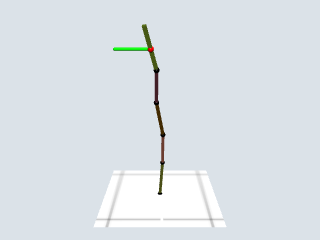

""

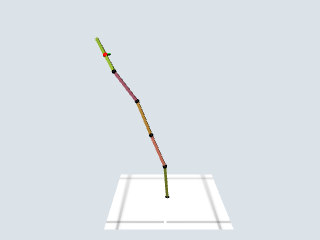

[0. 0. 0.]
3


In [255]:
with open('../urdf/branch_base.xml', 'r') as f:
  branch_xml = f.read()

BRANCH_STIFFNESS = 295
NUM_SEGMENTS = 5
PROBE_HEIGHT = 0.65
editor = CaneEditor(branch_xml)
editor.build_branch(total_length=0.8, num_segments=NUM_SEGMENTS, radius=0.006, def_stiff=BRANCH_STIFFNESS)
editor.randomize_joint_angles()
zero_pos = editor.get_zero_springref_pos()
editor.redefine_probe(PROBE_HEIGHT, zero_pos)
# print(f"last_site_pos: {last_site_pos}")
editor.show_model_at_pos(zero_pos)
editor.show_model_at_pos_with_camera(zero_pos, 1)

k_equiv = 1/((1/BRANCH_STIFFNESS) * NUM_SEGMENTS)

model = editor.model
print(model.body_inertia[model.body("branch_body_0").id])
print(model.body("branch_body_0").id)
# Display the edited XML
# editor.print_xml()


### Global Simulation Parameters

These parameters don't change between the two simulations, so we initialize them here to minimize confusion. 

In [ ]:
FRAMERATE = 60      # Frames per second for rendering

KU = 625    # Ultimate gain for the PID controller
TU = 0.095
pid = PID(Kp=KU*.5, Ki=55, Kd=3*KU*TU, output_limits=(-10, 50))

### First Simulation Run

This simulation run starts the model with the following conditions:
- all branch joints are at their spring reference positions
- the probe joint is at its initial height and its pushing end is at (0,0) in x,y. 
- a higher timestep is used to speed up the process.

The run moves the probe forward along the y axis until it senses contact with the branch, and then stops immediately. The actuator values are set to zero, and the position is saved for later use. 

### Second Simulation Run

A new simulation data object is set up for this run. The position data is taken from the previous sim to initialize this simulation. 

In [ ]:
# initialize the state of the simulation
data = mujoco.MjData(model)
data.qpos[:] = zero_pos  # set the initial position to the initial contact point
# data.qpos[0] = init_probe_x  # set the initial position of the probe
# init_probe_pos = contact_qpos[0]

# simulation-specific settings
model.opt.timestep = .00001
DURATION = 45
datacap_rate = 100 # Hz
CTRL_POS = 0 # 1 mm
pid.setpoint = 0
CTRL_POS_UPDATE_RATE = 1 # s

# variables to put data into lists for later plotting
timevals = []
posvals = []
velvals = []
forcevals = []
contact_x_forces = []
frames_stepped = []

with mujoco.Renderer(model, width=640, height=480) as renderer:
  time_since_last_ctrl_update = 0.0
  while data.time < DURATION:
    if time_since_last_ctrl_update >= CTRL_POS_UPDATE_RATE:
      time_since_last_ctrl_update = 0.0
      CTRL_POS += 0.001
      pid.setpoint = CTRL_POS
      print(f"Time is now {data.time:.3f} s, setting control position to {CTRL_POS:.4f} m")

    # control loop
    current_position = data.qpos[0]
    ctrl_force = pid(current_position)
    ctrl_force = k_equiv*(pid.setpoint)/PROBE_HEIGHT+pid(current_position) # relying on sin(theta) appx = theta for small angles
    
    # ctrl_force = pid(current_position)
    data.ctrl[0] = ctrl_force

    # step the simulation 

    # update the values 
    mujoco.mj_step(model, data)

    # -- write data to lists for later plotting --
    if len(timevals) < data.time*datacap_rate:
      # print(f"Feedforward term: {abs(k_equiv*(data.qpos[0]-contact_qpos[0])):.4f}, PID term: {pid(current_position):.4f}")
      timevals.append(data.time)
      posvals.append(data.qpos.copy())
      velvals.append(data.qvel.copy())
      forcevals.append(data.actuator_force.copy())

      # --- Isolate x-aligned contact force between probe and branch ---
      x_force = 0.0
      if data.ncon > 0:
        for i in range(data.ncon):
            contact = data.contact[i]
            # Get the body IDs for the two geoms in contact
            body1_id = model.geom_bodyid[contact.geom1]
            body2_id = model.geom_bodyid[contact.geom2]
            # Get the body names
            body1 = model.body(body1_id).name
            body2 = model.body(body2_id).name
            # Check if this contact includes the probe_link
            if "probe_link" in [body1, body2]:
                # Get the contact force (6D: [fx, fy, fz, tx, ty, tz])
                force = np.zeros(6)
                mujoco.mj_contactForce(model, data, i, force)
                # Rotate the force into the world frame from the contact frame
                R = np.array(contact.frame).reshape(3,3)
                force_world = R @ force[:3]
                # Add the x-component (force[0]) in the contact frame
                x_force += force_world[0]
        contact_x_forces.append(x_force)
      else:
        contact_x_forces.append(0.0)
    
    # -- frame rendering --
    if len(frames_stepped) < data.time*FRAMERATE:
      renderer.update_scene(data)
      pixels = renderer.render()
      frames_stepped.append(pixels)

    time_since_last_ctrl_update += model.opt.timestep

# frames = frames_preprocess + frames_stepped
media.show_video(frames_stepped, fps=FRAMERATE)


In [ ]:
dpi = 120
width = 1200
height = 400
figsize = (width/dpi, height/dpi)
fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

pos_array = np.array(posvals)  # shape: (timesteps, njnt)
  # shape: (timesteps, njnt)
for j in range(model.njnt):
    # Get joint name using the MuJoCo API
    joint_name = model.joint(j).name
    # don't plot if joint name contains "branch joint x"ArithmeticError
    if "x" not in joint_name:
        ax.plot(timevals, pos_array[:, j]-zero_pos[j], label=joint_name)


ax.set_title("Joint Positions")
ax.set_ylabel("Joint Position (m or radians)")
ax.set_xlabel("Time (seconds)")

# Add a reference line that steps up by 0.001 every 1 second
step_height = 0.001
step_interval = 1.0
step_times = np.arange(0, timevals[-1]+step_interval, step_interval)
step_values = np.arange(0, step_height*len(step_times), step_height)
# Interpolate to match the timevals for plotting as a step function
step_ref = np.zeros_like(timevals)
for i, t in enumerate(timevals):
    idx = np.searchsorted(step_times, t, side='right')
    step_ref[i] = step_values[idx-1] 
ax.step(timevals, step_ref, where='post', linestyle='--', color='black', label='0.001 step every 1s')
ax.legend()
ax.grid(True)

# filename = f"../images/plots/joint_positions_kv{int(model.actuator(0).gainprm[0])}_dt{model.opt.timestep}.png"
# fig.savefig(filename)

In [ ]:
force_array = np.array(forcevals)  # shape: (timesteps, n_actuator)
fig, ax = plt.subplots(figsize=(8, 4))
for i in range(model.nu):
    actuator_name = model.actuator(i).name
    ax.plot(timevals, force_array[:, i], label=actuator_name)
ax.set_title("Actuator Force Over Time")
ax.set_ylabel("Force (N or Nm)")
ax.set_xlabel("Time (seconds)")
ax.legend()
ax.grid(True)

In [ ]:
# Plot x-aligned contact force between probe and branch over time
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(timevals, contact_x_forces, label="Contact X Force (probe-branch)")
ax.set_title("X-Aligned Contact Force Between Probe and Branch")
ax.set_ylabel("Force (N)")
ax.set_xlabel("Time (seconds)")
ax.legend()
ax.grid(True)

# filename = f"../images/plots/x_force_kv{int(model.actuator(0).gainprm[0])}_dt{model.opt.timestep}.png"
# fig.savefig(filename)

In [ ]:
# PROBE_HEIGHT = 0.75  # height of probe above branch in meters
branch_max_disp = pos_array[-1, 0] # branch displacement at the end of the run
print(f"Final branch displacement: {branch_max_disp:.3f} rad")
napkin_math_force = (295* branch_max_disp)/PROBE_HEIGHT
# napkin_math_force = (295* branch_max_disp + .15*branch_max_vel)/.75
print(f"Napkin math force: {napkin_math_force:.3f} N")
print(f"Final contact x force: {contact_x_forces[-1]:.3f} N")
print("Last actuator force:", forcevals[-1])

os.system('aplay /usr/share/sounds/sound-icons/cembalo-1.wav &')

print(f"Last probe position: {data.qpos[0]:.6f} m")

      <geom size="0.01 0.01 0.01" pos="0.1 0 0" type="box" rgba="1 0 0 1"/>
      <geom size="0.005 0.0175" pos="0.0975 0 0" quat="0.707107 0.707106 0 0" type="cylinder" rgba="1 0 0 1"/>
      <geom size="0.005 0.025" pos="0.1225 0.0175 0" quat="0.704433 -0.0614407 0.704432 0.0614408" type="cylinder" rgba="1 0 0 1"/>
      <geom size="0.005 0.025" pos="0.1225 -0.0175 0" quat="0.704433 0.0614407 0.704432 -0.0614408" type="cylinder" rgba="1 0 0 1"/>

In [ ]:
# set up the state of the simulation
data = mujoco.MjData(model)
data.qpos[:] = zero_pos  # set the initial position to the zero springref position

# sim-specific settings
model.opt.timestep = .00001
CTRL_VEL = 0.01

# sim-specific container setup
contact_flag = False
frames_preprocess = []

with mujoco.Renderer(model, width=640, height=480) as renderer:
  while contact_flag == False:
   
    # control loop
    pid.setpoint = CTRL_VEL*data.time
    current_position = data.qpos[0]
    ctrl_force = pid(current_position) # relying on sin(theta) appx = theta for small angles
    data.ctrl[0] = ctrl_force

    # step the simulation 
    mujoco.mj_step(model, data)

    # -- frame rendering --
    if len(frames_preprocess) < data.time*FRAMERATE:
      renderer.update_scene(data)
      pixels = renderer.render()
      frames_preprocess.append(pixels)

    if data.ncon > 0:
        for i in range(data.ncon):
            contact = data.contact[i]
            # Get the body IDs for the two geoms in contact
            body1_id = model.geom_bodyid[contact.geom1]
            body2_id = model.geom_bodyid[contact.geom2]
            # Get the body names
            body1 = model.body(body1_id).name
            body2 = model.body(body2_id).name

            if "probe_link" in [body1, body2]:
                contact_flag = True
                print(f"Contact detected between {body1} and {body2} at time {data.time:.3f}s")
                # data.ctrl[0] = 0
                break

contact_qpos = data.qpos.copy()
print(f"Final position: {contact_qpos[0]:.4f} at time {data.time:.3f}s")
# media.show_video(frames, fps=framerate)